In [2]:
using JLD2, FileIO
using Plots

data_loc = "simulation_results_mp.jld2"

N_vals = 10:10:80
σ_vals = [0.000, 0.001, 0.002]

3-element Vector{Float64}:
 0.0
 0.001
 0.002

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588


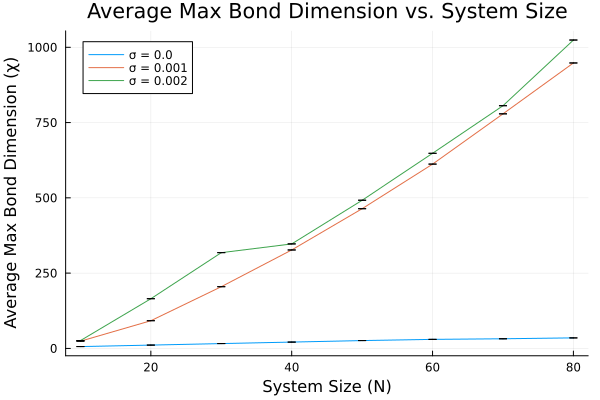

In [3]:
function plot_bond_dim_vs_N(N_vals, σ_vals, data_loc)
    
    gr() 
    bond_dim_plot = plot(
        title = "Average Max Bond Dimension vs. System Size",
        xlabel = "System Size (N)",
        ylabel = "Average Max Bond Dimension (χ)",
        legend = :topleft
    )
    
    if !isfile(data_loc)
        println("Error: Results file not found at '$data_loc'")
        println("Please run your 'get_data.jl' simulation script first.")
        return
    end
    

    jldopen(data_loc, "r") do file

        for σ in σ_vals
            plot_N = Float64[]
            plot_chi = Float64[]
            plot_chi_err = Float64[]
            
    
            for N in N_vals
                group_path = "N=$(N)/sigma=$(σ)"
                
        
                if haskey(file, group_path)
        
                    avg_chi = file[group_path]["avg_bond_dim"]
                    err_chi = file[group_path]["err_bond_dim"]
                    
          
                    push!(plot_N, N) 
                    push!(plot_chi, avg_chi)
                    push!(plot_chi_err, err_chi)
                else
                    println("Warning: Missing data for N=$N, σ=$σ. Skipping this point.")
                end
            end
            

            if !isempty(plot_N)
                plot!(
                    bond_dim_plot,
                    plot_N, 
                    plot_chi,
                    yerror = plot_chi_err, 
                    label = "σ = $σ",
                    markersize = 4,
                    capstyle = :round 
                )
            else
                println("No data found for σ = $σ.")
            end
        end
    end
    
    display(bond_dim_plot)

end

plot_bond_dim_vs_N(N_vals, σ_vals, data_loc)

┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8ZnR3/src/axes.jl:75
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8ZnR3/src/axes.jl:75
┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8ZnR3/src/axes.jl:75
┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8ZnR3/src/axes.jl:75
┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8ZnR3/src/axes.jl:75
┌ Warning: Skipped yaxis arg scientific
└ @ Plots ~/.julia/packages/Plots/8

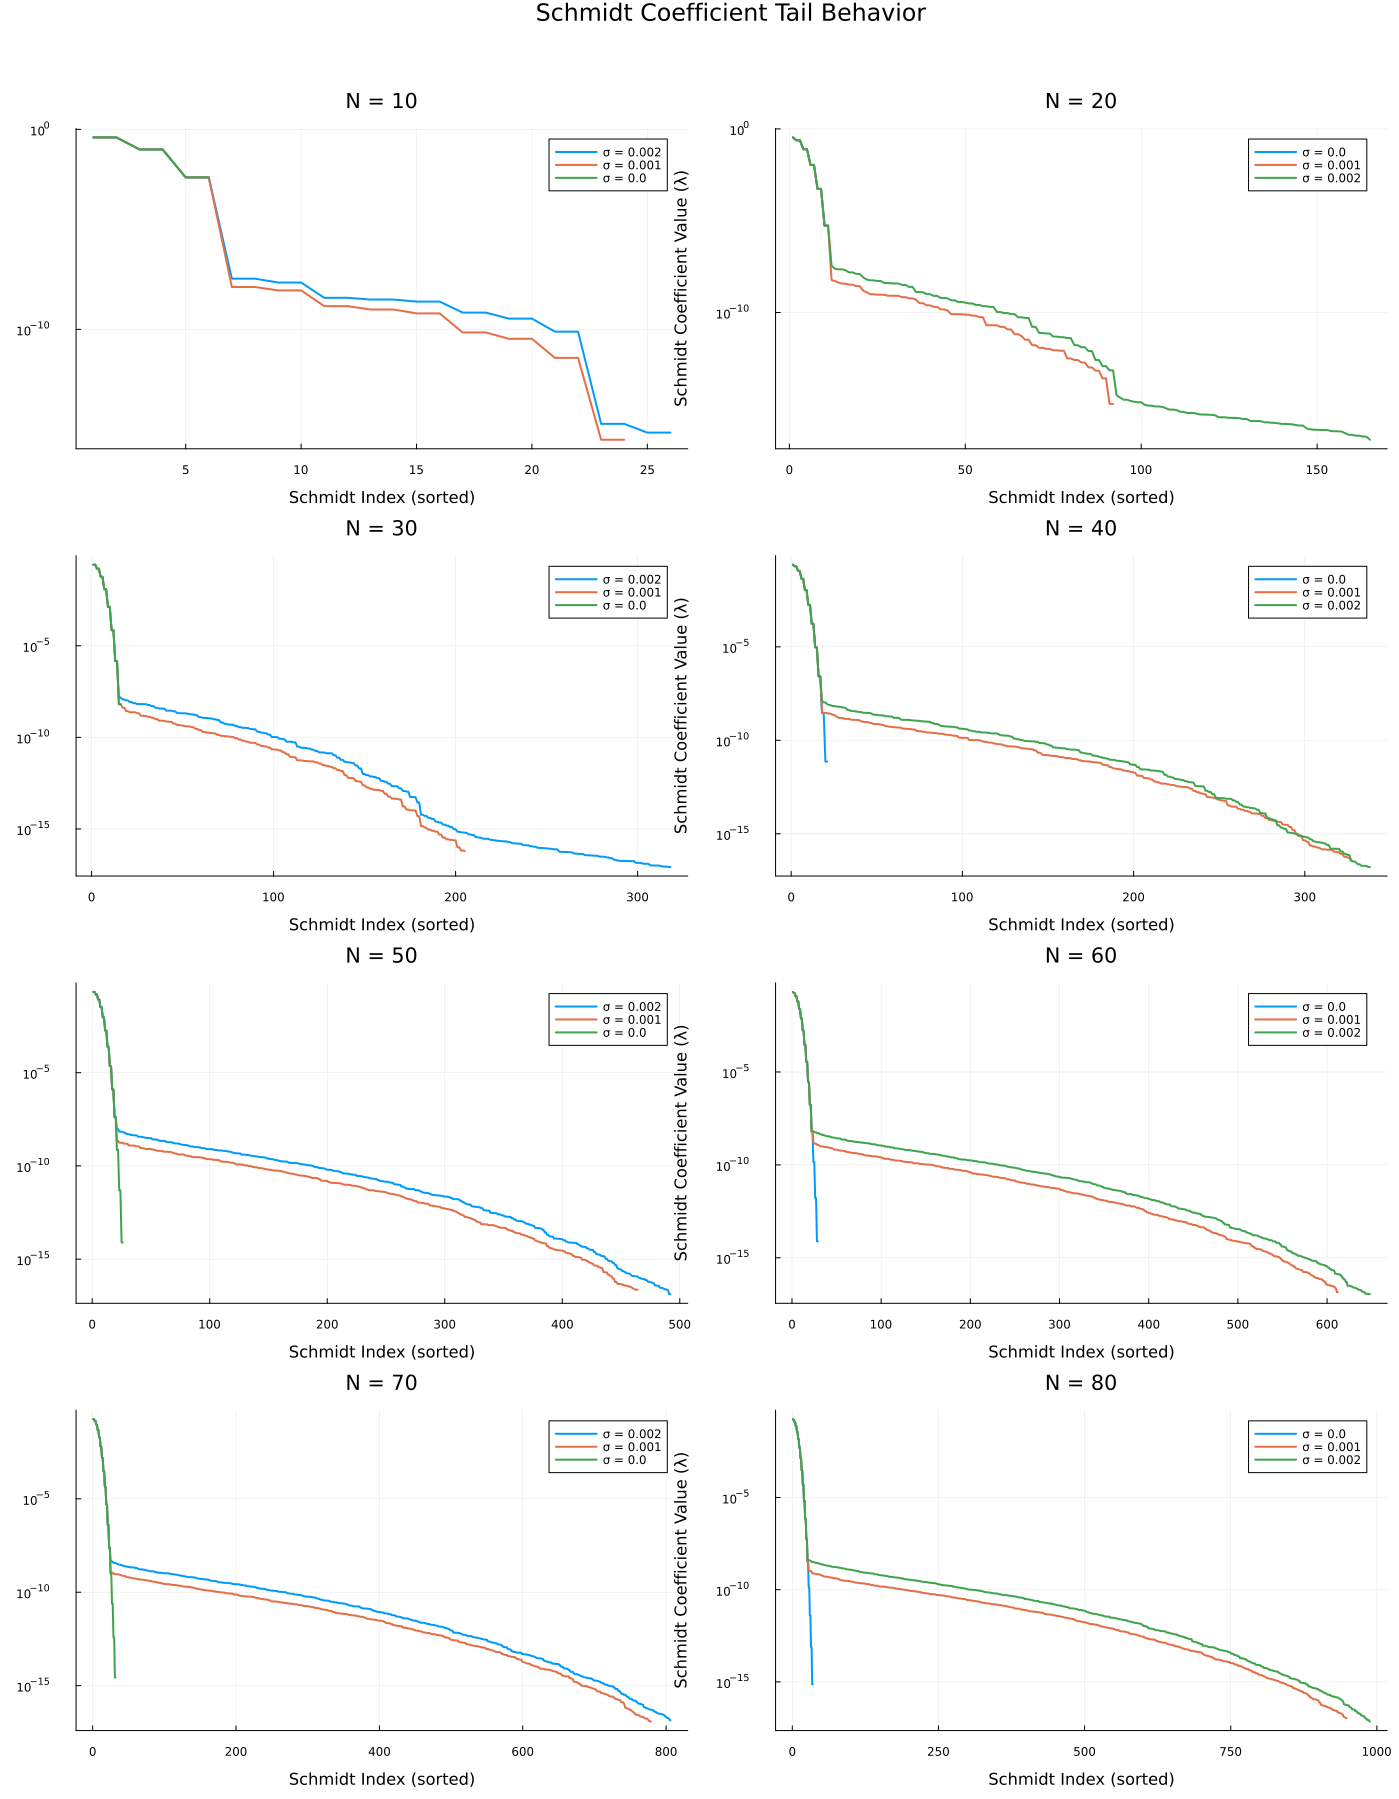

Plot saved to schmidt_coefficient_tails_first_run.png


In [4]:
function plot_schmidt_coefficient_tail_comparison_first_run(N_vals, σ_vals, data_loc)
    """
    Create plots showing Schmidt coefficients sorted by magnitude using the SAME data
    as the entropy contributions plot (first run only).
    """
    
    if !isfile(data_loc)
        println("Error: Results file not found at '$data_loc'")
        return
    end

    gr()
    plot_list = []
    
    jldopen(data_loc, "r") do file
        for N in N_vals
            subplot = plot(
                title = "N = $N",
                xlabel = "Schmidt Index (sorted)",
                ylabel = "Schmidt Coefficient Value (λ)",
                yscale = :log10,
                legend = :topright,
                yaxis = (formatter = :scientific),
            )
            
            for σ in reverse!(σ_vals)
                group_path = "N=$(N)/sigma=$(σ)"
                
                if haskey(file, group_path)
                    all_run_coefs = file[group_path]["schmidt_coefs"]
                    
                    first_run = all_run_coefs[1]
                    
                    if first_run isa Vector{Float64}
                        run_coefs = first_run
                    else
                        run_coefs = first_run.storage.data
                    end
                    
                    spectrum = run_coefs .^ 2
                    # spectrum = spectrum[spectrum .> 1e-15]
                    spectrum ./= sum(spectrum)
                    
                    sorted_indices = sortperm(spectrum, rev=true)
                    sorted_spec = spectrum[sorted_indices]
                    
                    x_vals = 1:length(sorted_spec)
                    
                    plot!(
                        subplot,
                        x_vals,
                        sorted_spec,
                        label = "σ = $σ",
                        linewidth = 2
                    )
                else
                    println("Warning: Missing data for N=$N, σ=$σ")
                end
            end
            
            push!(plot_list, subplot)
        end
    end
    
    final_plot = plot(
        plot_list...,
        layout = (4, 2),
        size = (1400, 1800),
        plot_title = "Schmidt Coefficient Tail Behavior"
    )
    
    display(final_plot)
    savefig(final_plot, "schmidt_coefficient_tails_first_run.png")
    println("Plot saved to schmidt_coefficient_tails_first_run.png")
end

plot_schmidt_coefficient_tail_comparison_first_run(N_vals, σ_vals, data_loc)

Now we want to confirm what the weight of the tail is (i.e. how much does it contribute to the overall VN entropy).

We will do this, by essentially finding the point at which the tail deviates from the $\sigma=0$ case, and summing up all those values. Let's first just see if we can just find that point from which the deviation occurs. We'll write a function to do this for one $N$ and one $\sigma \neq 0$.

In [5]:
function sorted_spec(N, σ)

    # we need to get the runs for the zero sigma case, and the sigma we entered. 

    if !isfile(data_loc)
        println("Error: results file not found at $data_loc")
        return nothing
    end

    jldopen(data_loc, "r") do file

        # Load σ data
        group_path_σ = "N=$(N)/sigma=$(σ)"
        if !haskey(file, group_path_σ)
            println("Warning: Missing data for N=$N, σ=$σ")
            return nothing
        end
        all_run_coefs_σ = file[group_path_σ]["schmidt_coefs"]
        first_run_σ = all_run_coefs_σ[1]
        if first_run_σ isa Vector{Float64}
            run_coefs_σ = first_run_σ
        else
            run_coefs_σ = first_run_σ.storage.data
        end
        spectrum_σ = run_coefs_σ .^ 2
        # spectrum_σ = spectrum_σ[spectrum_σ .> 1e-15]
        spectrum_σ ./= sum(spectrum_σ)
        sorted_spec_σ = sort(spectrum_σ, rev=true)

        return sorted_spec_σ

    end # end jldopen

end

sorted_spec (generic function with 1 method)

In [6]:
sorted_spec_0000 = sorted_spec(50, 0.00)
sorted_spec_0001 = sorted_spec(50, 0.001)
sorted_spec_0002 = sorted_spec(50, 0.002)

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing

492-element Vector{Float64}:
 0.21392592958624593
 0.2139259295862441
 0.15717247053859035
 0.1571724705385896
 0.08452644299080202
 0.08452644299079642
 0.033019654047806095
 0.033019654047795444
 0.00925520861155709
 0.009255208611554102
 0.0018283288698061914
 0.0018283288697850486
 0.00024818924398298817
 ⋮
 3.7607862968065194e-17
 3.760786210873161e-17
 2.9641759547414484e-17
 2.961105675071508e-17
 2.7600421814771014e-17
 2.757751992608378e-17
 2.4213614402621422e-17
 2.370237079807692e-17
 2.3685058543364174e-17
 2.133384124250395e-17
 1.3124781685100149e-17
 1.3124781667143388e-17

In [7]:
function find_tail_divergence(clean_spec, disordered_spec; ratio_threshold=5.0, min_val=1e-20)

    for i in 1:min(length(clean_spec), length(disordered_spec))
        val_clean = clean_spec[i]
        val_disordered = disordered_spec[i]
        
        if val_clean < min_val
            if val_disordered > min_val * 10
                return i
            else
                continue 
            end
        end
        ratio = val_disordered / val_clean
        
        if ratio > ratio_threshold
            return i
        end
    end
    
    return length(clean_spec) # Fallback if no deviation found
end

deviation_idx = find_tail_divergence(sorted_spec_0000, sorted_spec_0002, ratio_threshold=5.0)

println("Deviation found at index: $deviation_idx")

Deviation found at index: 21


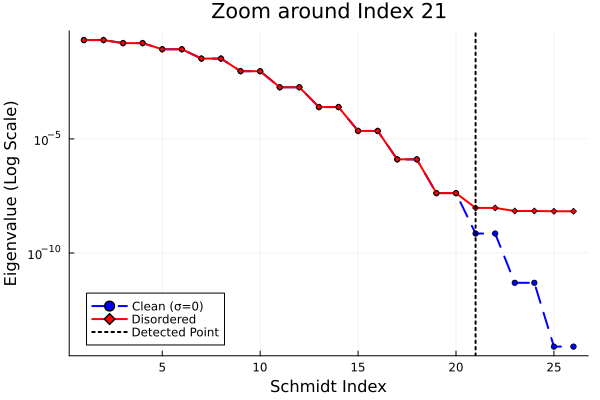

In [8]:
function verify_deviation_zoom(clean_spec, disordered_spec, dev_idx; window=15)
    # 1. Define the safe zoom window (clamping to array bounds)
    len = min(length(clean_spec), length(disordered_spec))
    start_idx = max(1, dev_idx - window)
    end_idx = min(len, dev_idx + window)
    
    # The x-axis range
    rng = start_idx:end_idx

    # 2. Base Plot
    p = plot(rng, clean_spec[rng], 
        label="Clean (σ=0)", 
        color=:blue, 
        linestyle=:dash, 
        linewidth=2,
        yscale=:log10,           # Crucial for seeing tails
        marker=:circle,          # distinct points help verify exact indices
        markersize=3,
        title="Zoom around Index $dev_idx",
        xlabel="Schmidt Index",
        ylabel="Eigenvalue (Log Scale)",
        legend=:bottomleft       # Moves legend out of the way of the tail usually
    )

    # 3. Add Disordered Data
    plot!(p, rng, disordered_spec[rng], 
        label="Disordered", 
        color=:red, 
        linewidth=2,
        marker=:diamond,
        markersize=3
    )

    # 4. Highlight the specific cut-off point
    vline!(p, [dev_idx], 
        label="Detected Point", 
        color=:black, 
        linewidth=2,
        linestyle=:dot
    )

    display(p)
end

# 1. Find the index (using the logic from the previous step)
dev_index = find_tail_divergence(sorted_spec_0000, sorted_spec_0002, ratio_threshold=5.0)

# 2. Visual Check
verify_deviation_zoom(sorted_spec_0000, sorted_spec_0002, dev_index, window=20)

In [9]:
function safe_xlogx(x)
    """handles error when computer tries to do logs with small numbers"""
    if x <= 1e-20
        return 0.0 # xlogx tends to this for small vals anyway
    end
    return x * log(x)
end

function find_body_entropy_contribution(sorted_spec, deivation_idx)
    truncated_sorted_spec = sorted_spec[1 : deviation_idx - 1]
    return sum(safe_xlogx(x) for x in truncated_sorted_spec)
end

function find_tail_entropy_contribution(sorted_spec, deviation_idx)
    truncated_sorted_spec = sorted_spec[deviation_idx : end]
    return sum(safe_xlogx(x) for x in truncated_sorted_spec)
end

find_tail_entropy_contribution (generic function with 1 method)

In [10]:
# find body and Tail

body_cnt_0000 = find_body_entropy_contribution(sorted_spec_0000, dev_index)
tail_cnt_0000 = find_tail_entropy_contribution(sorted_spec_0000, dev_index)
total_ent_0000 = body_cnt_0000 + tail_cnt_0000
bt_ratio_0000 = body_cnt_0000 / tail_cnt_0000

body_cnt_0002 = find_body_entropy_contribution(sorted_spec_0002, dev_index)
tail_cnt_0002 = find_tail_entropy_contribution(sorted_spec_0002, dev_index)
total_ent_0002 = body_cnt_0002 + tail_cnt_0002
bt_ratio_0002 = body_cnt_0002 / tail_cnt_0002

diff_body = abs(body_cnt_0000 - body_cnt_0002)
diff_tail = abs(tail_cnt_0000 - tail_cnt_0002)
total_err = abs(total_ent_0000 - total_ent_0002)

println("Body contributions: 0.000 -> $body_cnt_0000, 0.002 -> $body_cnt_0002")
println("Tail contributions: 0.000 -> $tail_cnt_0000, 0.002 -> $tail_cnt_0002")
println("BT Ratio: 0.000 -> $bt_ratio_0000, 0.002 -> $bt_ratio_0002")
println("Total contributions: 0.000 -> $total_ent_0000, 0.002 -> $total_ent_0002")
println("Abs Err in total contributions: $total_err")
println("Diff: Body -> $diff_body, Tail -> $diff_tail")


Body contributions: 0.000 -> -1.998723733693351, 0.002 -> -1.9987473372712854
Tail contributions: 0.000 -> -3.025018655563471e-8, 0.002 -> -5.0740817429012256e-6
BT Ratio: 0.000 -> 6.607310437631163e7, 0.002 -> 393913.11345497845
Total contributions: 0.000 -> -1.9987237639435376, 0.002 -> -1.9987524113530284
Abs Err in total contributions: 2.8647409490822895e-5
Diff: Body -> 2.3603577934405706e-5, Tail -> 5.043831556345591e-6


We can do this more generally and just get the truncation error (in terms of pure values).

In [11]:
function truncation_error(sorted_spec, dev_idx)
    truncated_sorted_spec = sorted_spec[dev_idx : end]
    return sum(truncated_sorted_spec)
end

truncation_error(sorted_spec_0002, dev_index)

2.5651384857098496e-7

In [12]:
using LinearAlgebra

function analyze_spectral_fidelity(spec1::Vector{T}, spec2::Vector{T}) where T <: Number

    len = max(length(spec1), length(spec2))
    p = zeros(T, len)
    q = zeros(T, len)
    
    p[1:length(spec1)] = spec1
    q[1:length(spec2)] = spec2
    
    if sum(p) > 0; p ./= sum(p); end
    if sum(q) > 0; q ./= sum(q); end

    bc_coeff = sum(sqrt.(p .* q))
    classical_fidelity = bc_coeff^2

    trace_dist = 0.5 * sum(abs.(p .- q))
    observable_bound = 2 * trace_dist

    return classical_fidelity, trace_dist, observable_bound
end

# --- Example Usage with your previous data ---
# (assuming sorted_spec_0 and sorted_spec_σ exist)

F, D, Bound = analyze_spectral_fidelity(sorted_spec_0000, sorted_spec_0002)
println("Max Possible Fidelity: $F")
println("Observable Bound (||O||=1): $Bound")

Max Possible Fidelity: 0.9999997528930474
Observable Bound (||O||=1): 2.4081591301462115e-5


Tail scaling with system size.

In [13]:
function tail_contribution_with_system_size(N_vals, σ_vals)
    results = Vector{Dict{String, Any}}()

    for N in N_vals

        sorted_spec_0 = sorted_spec(N, 0.00)
        
        if sorted_spec_0 === nothing
            println("Skipping N=$N: No σ=0 data found.")
            continue
        end

        for σ in σ_vals
            # Skip 0.0 if it's in the list, as we compare AGAINST 0.0
            if σ == 0.0
                continue 
            end

            sorted_spec_σ = sorted_spec(N, σ)

            if sorted_spec_σ === nothing
                println("Skipping N=$N, σ=$σ: No data found.")
                continue
            end

            dev_idx = find_tail_divergence(sorted_spec_0, sorted_spec_σ)
            truncation_err = truncation_error(sorted_spec_σ, dev_idx)
            body_cnt_σ = find_body_entropy_contribution(sorted_spec_σ, dev_idx)
            tail_cnt_σ = find_tail_entropy_contribution(sorted_spec_σ, dev_idx)

            fidelity, trace_dist, observable_bound = analyze_spectral_fidelity(sorted_spec_0, sorted_spec_σ)

            results_dict = Dict(
                "N" => N,
                "σ" => σ,
                "dev_idx" => dev_idx,
                "truncation_err" => truncation_err,
                "body_contribution" => body_cnt_σ,
                "tail_contribution" => tail_cnt_σ,
                "total_entropy" => body_cnt_σ + tail_cnt_σ,
                "tail_fraction" => tail_cnt_σ / (body_cnt_σ + tail_cnt_σ), # Useful metric
                "fidelity" => fidelity,
                "trace_dist" => trace_dist,
                "observable_bound" => observable_bound
            )

            push!(results, results_dict)
            
        end # σ loop
    end # N loop

    return results
end

results = tail_contribution_with_system_size(N_vals, [0.001, 0.002])

┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Tensor{Float64,1,JLD2.ReconstructedMutable{Symbol("Dense{Float64,Vector{Float64}}"), (:data,), Tuple{Any}},Tuple{Int64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/WDhXU/src/data/reconstructing_datatypes.jl:588
┌ Warning: type NDTensors.Dense{Float64,Vector{Float64}} does not exist in workspace; reconstructing

16-element Vector{Dict{String, Any}}:
 Dict("fidelity" => 0.9999999495763203, "observable_bound" => 1.960570458020388e-5, "tail_fraction" => 0.01744355438229648, "tail_contribution" => -0.021940328151248707, "truncation_err" => 0.0039676890704699215, "dev_idx" => 6, "N" => 10, "σ" => 0.001, "total_entropy" => -1.2577899933924028, "body_contribution" => -1.2358496652411541…)
 Dict("fidelity" => 0.9999998665792642, "observable_bound" => 1.0467082187258557e-5, "tail_fraction" => 0.017445556714301178, "tail_contribution" => -0.0219430622015267, "truncation_err" => 0.003968059979885208, "dev_idx" => 6, "N" => 10, "σ" => 0.002, "total_entropy" => -1.2578023482356768, "body_contribution" => -1.2358592860341502…)
 Dict("fidelity" => 0.9999999480946882, "observable_bound" => 2.424824843651472e-5, "tail_fraction" => 4.2860556528797127e-5, "tail_contribution" => -6.669292162625259e-5, "truncation_err" => 5.4666838721737735e-6, "dev_idx" => 11, "N" => 20, "σ" => 0.001, "total_entropy" => -1.556044

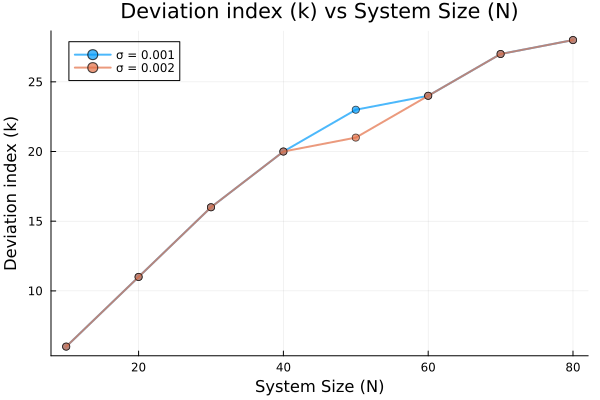

In [14]:
using Plots

function plot_deviated_index(results)
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    p = plot(
        title = "Deviation index (k) vs System Size (N)",
        xlabel = "System Size (N)",
        ylabel = "Deviation index (k)",
        legend = :topleft,
        grid = true,
        bg_legend = :transparent,
    )
    
    for σ in unique_sigmas
        sigma_data = filter(d -> d["σ"] == σ, results)
    
        sort!(sigma_data, by = d -> d["N"])
        
        x_vals = [d["N"] for d in sigma_data]
        y_vals = [d["dev_idx"] for d in sigma_data]
        
        plot!(p, x_vals, y_vals, 
            label = "σ = $σ", 
            marker = :circle, 
            linewidth = 2,
            alpha=0.7
        )
    end
    
    return p
end

plot_deviated_index(results)

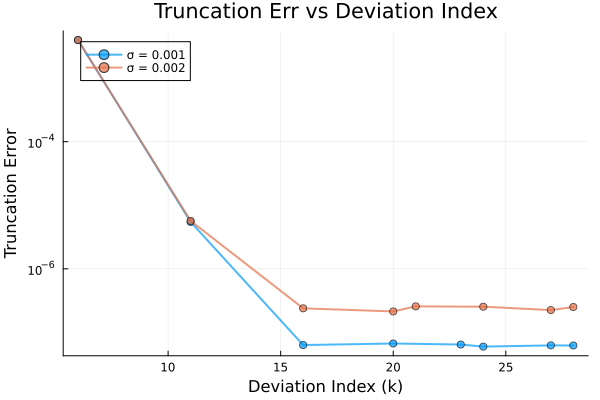

In [15]:
using Plots

function plot_deviated_index(results)
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    p = plot(
        title = "Truncation Err vs Deviation Index",
        xlabel = "Deviation Index (k)",
        ylabel = "Truncation Error",
        legend = :topleft,
        grid = true,
        bg_legend = :transparent,
        yscale = :log
    )
    
    for σ in unique_sigmas
        sigma_data = filter(d -> d["σ"] == σ, results)
    
        sort!(sigma_data, by = d -> d["N"])
        
        x_vals = [d["dev_idx"] for d in sigma_data]
        y_vals = [d["truncation_err"] for d in sigma_data]
        
        plot!(p, x_vals, y_vals, 
            label = "σ = $σ", 
            marker = :circle, 
            linewidth = 2,
            alpha=0.7
        )
    end
    
    return p
end

plot_deviated_index(results)

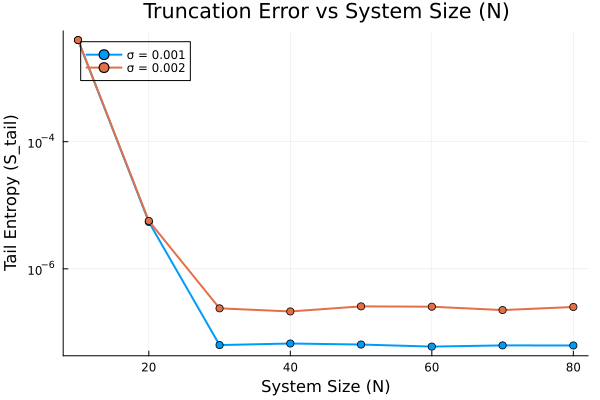

In [16]:
using Plots

function plot_truncation_err_vs_N(results)
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    p = plot(
        title = "Truncation Error vs System Size (N)",
        xlabel = "System Size (N)",
        ylabel = "Tail Entropy (S_tail)",
        legend = :topleft,
        grid = true,
        bg_legend = :transparent,
        yscale = :log,
        yaxis=:log
    )
    
    for σ in unique_sigmas
        sigma_data = filter(d -> d["σ"] == σ, results)
    
        sort!(sigma_data, by = d -> d["N"])
        
        x_vals = [d["N"] for d in sigma_data]
        y_vals = [d["truncation_err"] for d in sigma_data]
        
        plot!(p, x_vals, y_vals, 
            label = "σ = $σ", 
            marker = :circle, 
            linewidth = 2
        )
    end
    
    return p
end

plot_truncation_err_vs_N(results)

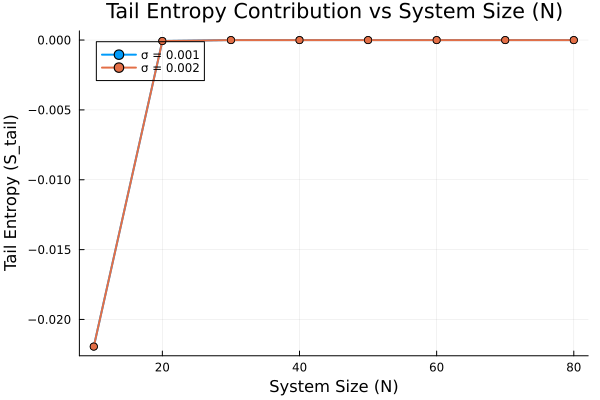

In [17]:
using Plots

"""
Plots the Absolute Tail Entropy (S_tail) as a function of System Size (N).
"""
function plot_tail_vs_N(results::Vector{Dict{String, Any}})
    # 1. Identify all unique disorder values to make separate lines
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    # 2. Setup the Canvas
    p = plot(
        title = "Tail Entropy Contribution vs System Size (N)",
        xlabel = "System Size (N)",
        ylabel = "Tail Entropy (S_tail)",
        legend = :topleft,
        grid = true,
        bg_legend = :transparent,
        # yscale = :log,
        # yaxis=:log
    )
    
    # 3. Loop through each sigma and plot a series
    for σ in unique_sigmas
        # Filter results for this specific sigma
        sigma_data = filter(d -> d["σ"] == σ, results)
        
        # Sort by N so the line connects points in order
        sort!(sigma_data, by = d -> d["N"])
        
        # Extract coordinates
        x_vals = [d["N"] for d in sigma_data]
        y_vals = [d["tail_contribution"] for d in sigma_data]
        
        # Plot line
        plot!(p, x_vals, y_vals, 
            label = "σ = $σ", 
            marker = :circle, 
            linewidth = 2
        )
    end
    
    display(p)
    return p
end

plot_tail_vs_N(results)

println("")

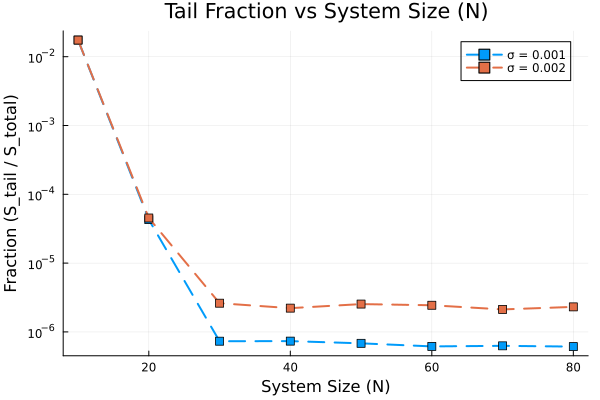

In [18]:
function plot_tail_fraction_vs_N(results::Vector{Dict{String, Any}})
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    p = plot(
        title = "Tail Fraction vs System Size (N)",
        xlabel = "System Size (N)",
        ylabel = "Fraction (S_tail / S_total)",
        legend = :topright,
        grid = true,
        bg_legend = :transparent,
        yscale= :log10
    )
    
    for σ in unique_sigmas
        sigma_data = filter(d -> d["σ"] == σ, results)
        sort!(sigma_data, by = d -> d["N"])
        
        x_vals = [d["N"] for d in sigma_data]
        y_vals = [d["tail_fraction"] for d in sigma_data]
        
        plot!(p, x_vals, y_vals, 
            label = "σ = $σ", 
            marker = :square, 
            linewidth = 2,
            linestyle = :dash
        )
    end
    
    # display(p)
    return p
end

plot_tail_fraction_vs_N(results)

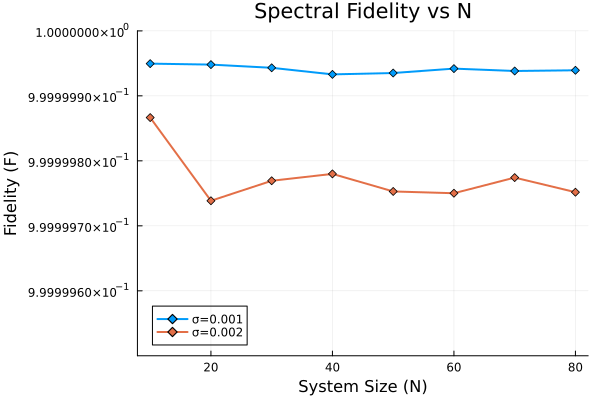

In [19]:
function plot_fidelity_vs_N(results::Vector{Dict{String, Any}})
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    # Linear scale is better for Fidelity since it's close to 1
    p = plot(title="Spectral Fidelity vs N", xlabel="System Size (N)", ylabel="Fidelity (F)",
             legend=:bottomleft, grid=true, bg_legend=:transparent,
             ylims=(0.9999995, 1.00)) # Zoom in near 1.0
    
    for σ in unique_sigmas
        data = filter(d -> d["σ"] == σ, results)
        sort!(data, by = d -> d["N"])
        x = Float64[d["N"] for d in data]; y = Float64[d["fidelity"] for d in data]
        
        plot!(p, x, y, label="σ=$σ", marker=:diamond, lw=2)
    end
    return p
end

plot_fidelity_vs_N(results)

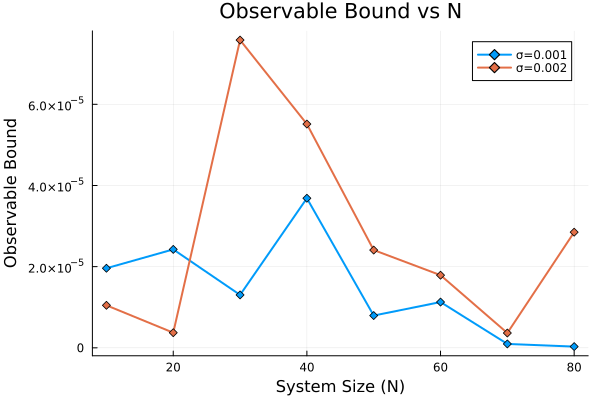

In [20]:
function plot_observable_error_vs_N(results::Vector{Dict{String, Any}})
    unique_sigmas = sort(unique([d["σ"] for d in results]))
    
    # Linear scale is better for Fidelity since it's close to 1
    p = plot(title="Observable Bound vs N", xlabel="System Size (N)", ylabel="Observable Bound",
             legend=:topright, grid=true, bg_legend=:transparent)
    
    for σ in unique_sigmas
        data = filter(d -> d["σ"] == σ, results)
        sort!(data, by = d -> d["N"])
        x = Float64[d["N"] for d in data]; y = Float64[d["observable_bound"] for d in data]
        
        plot!(p, x, y, label="σ=$σ", marker=:diamond, lw=2)
    end
    return p
end

plot_observable_error_vs_N(results)

In [ ]:
using Pkg
Pkg.add(["LinearAlgebra", "ITensors", "ITensorMPS", "Statistics", "JLD2", "FileIO"])

using LinearAlgebra
using ITensors
using ITensorMPS
using Statistics
using JLD2, FileIO

function generate_fully_connected_wam(N::Int, σ::Float64; μ::Float64=1.0)
    """
    Create a weighted adjacency matrix for a fully connected graph of N nodes. μ should always be one really.
    """
 
    A = zeros(Float64, N, N)
    for i in 1:N
        for j in (i+1):N
            weight = μ + σ * randn() # weight from normal distribution with mean μ and std σ
            A[i, j] = weight
            A[j, i] = weight 
        end
    end
    return A
end 

function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    """Create the XXZ Hamiltonian as an MPO given an adjacency matrix."""
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            weight = adj_mat[i, j]
            if weight != 0.0
                # XX and YY terms: S+S- + S-S+ = 2(SxSx + SySy)
                # So to get J(SxSx + SySy), we need J/2 * (S+S- + S-S+)
                ampo += weight * J/2, "S+", i, "S-", j
                ampo += weight * J/2, "S-", i, "S+", j
                # ZZ term
                ampo += weight * J * Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end 

function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

function create_MPS(L::Int, conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    # USE create_custom_MPS TO SET A DIFFERENT INIT STATE
    ψ0 = MPS(sites, init_state)
    return ψ0, sites
end

function find_ground_state_mps(N, J, Δ, σ, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)
    ψ_mps_N, sites_N = create_MPS(N)
    wam_N = generate_fully_connected_wam(N, σ; μ)
    H_N = create_xxz_hamiltonian_mpo(N, wam_N, J, Δ, sites_N)
    _, ψ_gs_N = solve_xxz_hamiltonian_dmrg(H_N, ψ_mps_N, NUM_SWEEPS, MAX_BOND_DIM, ACC)
    return ψ_gs_N
end

function get_entanglement_data(psi, b)
    orthogonalize!(psi, b)
    s = siteind(psi, b)
    
    local U, S, V
    if b==1
        # no link to left, edge case
        U, S, V = svd(psi[b], (s,))
    else
        l = linkind(psi, b-1)
        U, S, V = svd(psi[b], (l, s))
    end

    schmidt_coefs = diag(S)
    schmidt_spectrum = schmidt_coefs .^ 2 # square all schmidt_coefs
    schmidt_spectrum = schmidt_spectrum[schmidt_spectrum .> 1e-20] # filter out really small p so we don't get NaN entropies
    schmidt_spectrum ./= sum(schmidt_spectrum) # normalise

    vn_entropy = -sum(p * log(p) for p in schmidt_spectrum) # von neuman entropy

    return schmidt_coefs, vn_entropy
end

function sort_spectrum(run_coefs)
    spectrum = run_coefs .^ 2
    # spectrum = spectrum[spectrum .> 1e-15]
    spectrum ./= sum(spectrum)
    
    sorted_indices = sortperm(spectrum, rev=true)
    sorted_spec = spectrum[sorted_indices]
    return sorted_spec
end

function get_bipartite_sorted_spectrum(gs_mps)
    b = ceil(Int, N / 2) # bipartite cut
    schmidt_coefs, _ = get_entanglement_data(gs_mps, b)
    return sort_spectrum(schmidt_coefs)
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


sort_spectrum (generic function with 1 method)

In [22]:
J = Δ = -1
μ = 1.0

NUM_SWEEPS = 30
MAX_BOND_DIM = typemax(Int) # as high as ram allows
ACC = eps(Float64) # machine precision

2.220446049250313e-16

In [ ]:
function find_approximation_MPS(N, σ, J, Δ, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)

    # first get mps ground state for this system
    # find deviation index k 
    # then find approximable state by limiting max bond dim to k
    
    # first do for sigma=0
    println("Finding ground state MPS states...")
    gs_mps_0 = find_ground_state_mps(N, J, Δ, 0.0, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)
    gs_mps_σ = find_ground_state_mps(N, J, Δ, σ, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)
    println("Found ground state MPS states.")

    # then find the deviation between these. We need the sorted Schmidt coefficients
    println("Finding Schmidt spectrums...")
    b = ceil(Int, N / 2) # bipartite cut
    schmidt_coefs_0, vn_entropy_0 = get_entanglement_data(gs_mps_0, b)
    schmidt_coefs_σ, vn_entropy_σ = get_entanglement_data(gs_mps_σ, b)
    sorted_spec_0 = sort_spectrum(schmidt_coefs_0)
    sorted_spec_σ = sort_spectrum(schmidt_coefs_σ)
    println("Found Schmidt spectrums.")

    # find deviated index

    println("Finding deviation index...")
    dev_idx = find_tail_divergence(sorted_spec_0, sorted_spec_σ)
    println("Found deviation index $dev_idx.")

    # approximable state is then the disordered state run with max bond dim as the dev index
    println("Finding approximate MPS ground state...")
    appx_gs_mps = find_ground_state_mps(N, J, Δ, σ, μ, NUM_SWEEPS, dev_idx, ACC)
    appx_bond_dim = maxlinkdim(appx_gs_mps)
    println("Found approximate MPS ground state with bond dimension $appx_bond_dim.")

    return appx_gs_mps, gs_mps_σ
    
end

find_approximation_MPS (generic function with 1 method)

In [40]:
apx_mps, actual_mps = find_approximation_MPS(30, 0.002, J, Δ, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)

Finding ground state MPS states...
Found ground state MPS states.
Finding Schmidt spectrums...
Found Schmidt spectrums.
Finding deviation index...
Found deviation index 16.
Finding approximate MPS ground state...
Found approximate MPS ground state with bond dimension 21.


(MPS
[1] ((dim=2|id=622|"S=1/2,Site,n=1") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=642|"Link,l=1") <Out>
 1: QN("Sz",-1) => 1
 2: QN("Sz",1) => 1)
[2] ((dim=4|id=821|"Link,l=2") <Out>
 1: QN("Sz",-2) => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",2) => 1, (dim=2|id=5|"S=1/2,Site,n=2") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=642|"Link,l=1") <In>
 1: QN("Sz",-1) => 1
 2: QN("Sz",1) => 1)
[3] ((dim=2|id=87|"S=1/2,Site,n=3") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=8|id=389|"Link,l=3") <Out>
 1: QN("Sz",-3) => 1
 2: QN("Sz",-1) => 3
 3: QN("Sz",1) => 3
 4: QN("Sz",3) => 1, (dim=4|id=821|"Link,l=2") <In>
 1: QN("Sz",-2) => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",2) => 1)
[4] ((dim=2|id=991|"S=1/2,Site,n=4") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=14|id=807|"Link,l=4") <Out>
 1: QN("Sz",-4) => 1
 2: QN("Sz",-2) => 4
 3: QN("Sz",0) => 4
 4: QN("Sz",2) => 4
 5: QN("Sz",4) => 1, (dim=8|id=389|"Link,l=3") <In>
 1: QN("Sz",-3) => 1
 2: QN("Sz",-1) => 3


In [ ]:
function appx_results(N_vals, σ_vals)
    results = Vector{Dict{String, Any}}()

    for N in N_vals
        for σ in σ_vals
            println("N=$N, σ=$σ")
            apx, act = find_approximation_MPS(N, σ, J, Δ, μ, NUM_SWEEPS, MAX_BOND_DIM, ACC)

            results_dict = Dict(
                "N" => N,
                "σ" => σ,
                "apx" => apx,
                "act" => act
            )

            push!(results, results_dict)
            
        end # σ loop
    end # N loop

    return results
end

N_vals = 10:10:60
results = appx_results(N_vals, [0.001, 0.002])

N=10, σ=0.001
Finding ground state MPS states...
Found ground state MPS states.
Finding Schmidt spectrums...
Found Schmidt spectrums.
Finding deviation index...
Found deviation index 6.
Finding approximate MPS ground state...
Found approximate MPS ground state with bond dimension 21.
N=10, σ=0.002
Finding ground state MPS states...
Found ground state MPS states.
Finding Schmidt spectrums...
Found Schmidt spectrums.
Finding deviation index...
Found deviation index 6.
Finding approximate MPS ground state...
Found approximate MPS ground state with bond dimension 21.
N=20, σ=0.001
Finding ground state MPS states...
Found ground state MPS states.
Finding Schmidt spectrums...
Found Schmidt spectrums.
Finding deviation index...
Found deviation index 11.
Finding approximate MPS ground state...
Found approximate MPS ground state with bond dimension 21.
N=20, σ=0.002
Finding ground state MPS states...
Found ground state MPS states.
Finding Schmidt spectrums...
Found Schmidt spectrums.
Finding de

LoadError: InterruptException:

In [ ]:
jldsave("appx_states.jld2", results)

In [ ]:
appx_states = jldopen("appx_states")